# Solución pronóstico adaptativo

### Por Luis Miguel Morales Álvarez
  

In [8]:
from os import listdir
from os.path import isfile, join

import numpy as np
import datetime
import xlrd

# los datos de todos los archivos
avg_prices = {}

data_dir = r'datos\precios'

for f in listdir(data_dir):
    file_dir = join(data_dir, f)
    if isfile(file_dir):
        book = xlrd.open_workbook(file_dir)
        sheet = book.sheet_by_index(0)
        flag1 = False
        last = -1
        for row in sheet.get_rows():
            date = row[0]
            if flag1:
                if date.ctype == xlrd.XL_CELL_EMPTY:
                    break
                date = datetime.datetime.strptime(date.value, '%Y-%m-%d').date() if date.ctype == xlrd.XL_CELL_TEXT else datetime.datetime(*xlrd.xldate_as_tuple(date.value, book.datemode)).date()
                day_prices = [x.value for x in row[1:last] if x.ctype == xlrd.XL_CELL_NUMBER]
                avg_day_price = np.average(day_prices)
                avg_prices[date] = avg_day_price
                
            elif date.value == 'Fecha':
                while row[last].ctype != xlrd.XL_CELL_TEXT or not str.isdigit(row[last].value):
                    last -= 1
                flag1 = True
               

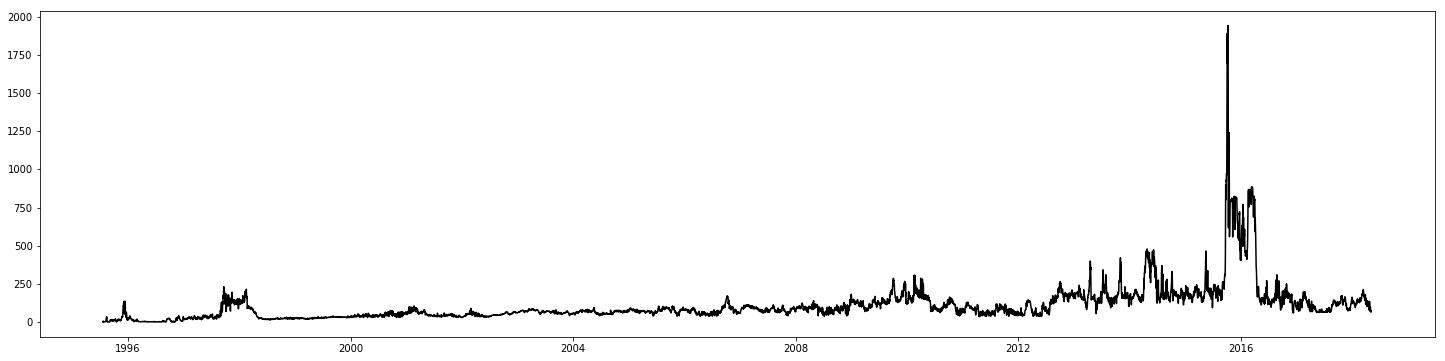

In [9]:
import matplotlib.pyplot as plt
import math
%matplotlib inline

lists = sorted(avg_prices.items())
f, d = zip(*lists)
f = list(f)
d = list(d)

plt.figure(figsize=(25,6))
plt.plot(f, d, color='black')

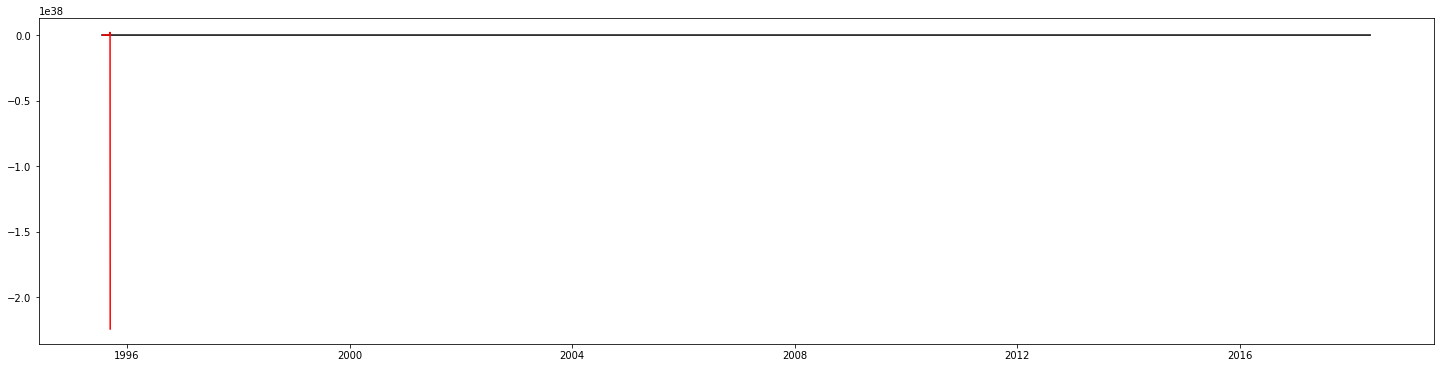

In [10]:
import tensorflow as tf
tf.enable_eager_execution()

class Model(object):
    def __init__(self, L):
        self.w = tf.Variable([0.0] * (L + 1))
        
    def __call__(self, x):
        x = tf.constant(np.array([1.0] + x, dtype=np.float32))
        return tf.reduce_sum(tf.multiply(self.w, x))
    
    def fit(self, mu, x, y_desired):
        y_pred = self(x)
        e = y_desired - y_pred
        x = tf.constant(np.array([1.0] + x, dtype=np.float32))
        self.w.assign_add(tf.scalar_mul(2 * mu * e, x))

def train_model(data, L, u):
    dl = len(data)
    model = Model(L)
    y_pred = np.empty(dl)
    y_pred[:] = np.nan

    for t in range(L, dl):
        x = data[t-L:t]
        y_pred[t] = model(x)
        model.fit(mu=u, x=x, y_desired=data[t])
        
    return model, y_pred

def plot_trained_model(data, y_pred):
    plt.figure(figsize=(25,6))
    plt.plot(f, data, color='black')
    plt.plot(f, y_pred, color='red')
    
_, y_pred = train_model(d, 5, 0.05)
plot_trained_model(d, y_pred)


Como se puede observar el modelo no puede ajustarse a los datos debido a los picos que se presentan en los datos originales y el modelo trata de adapartarse demasiado alto o demasiado bajo, por lo que se requiere transformar los datos usandon la transformación boxcox usando la libreria scipy.

0.20334415445861628


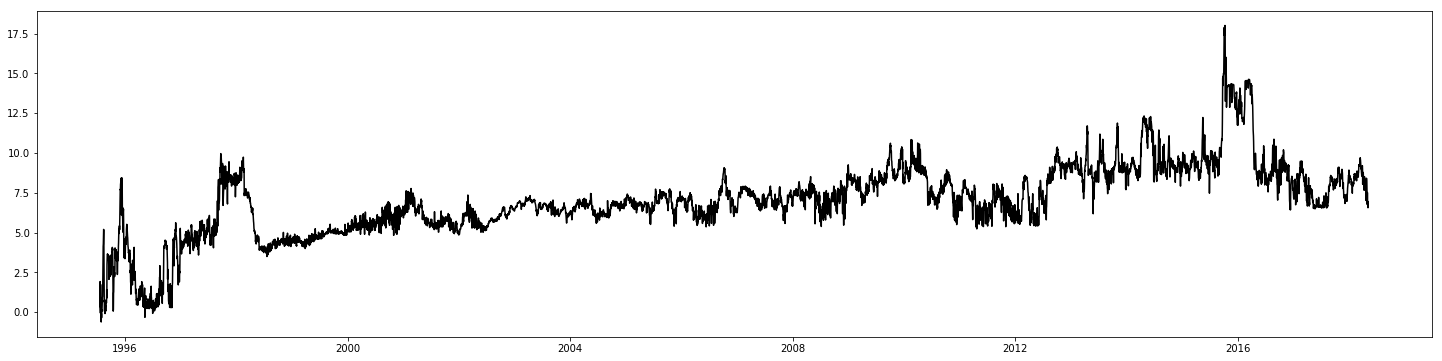

In [11]:
from scipy import stats

d_old = d
d, alpha = stats.boxcox(d_old)
d = d.tolist()
print(alpha)

plt.figure(figsize=(25,6))
plt.plot(f, d, color='black')

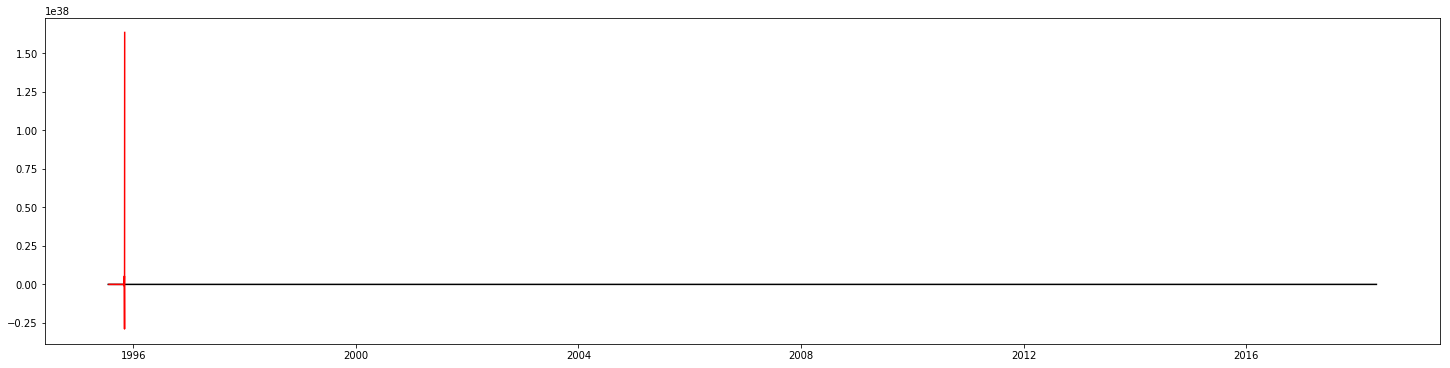

In [12]:
_, y_pred = train_model(d, 5, 0.05)
plot_trained_model(d, y_pred)

Como el modelo aun no se ajusta, por lo que se procedera a transformar los datos aun mas normalizandolos de [0, 1]

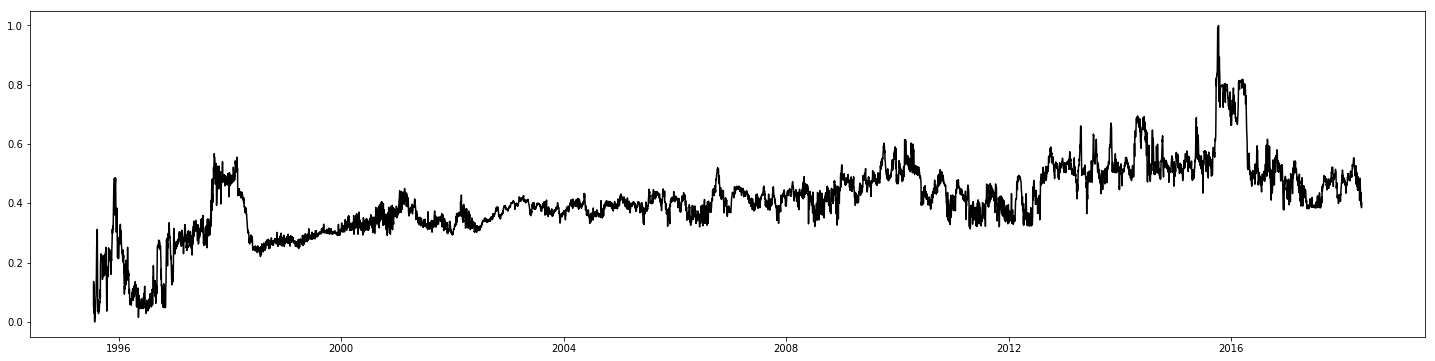

In [13]:
def normalize(x):
    mn = min(x)
    mx = max(x)
    df = mx - mn
    return [(t - mn)/df for t in x], mn, mx

d,_,_ = normalize(d)
plt.figure(figsize=(25,6))
plt.plot(f, d, color='black')

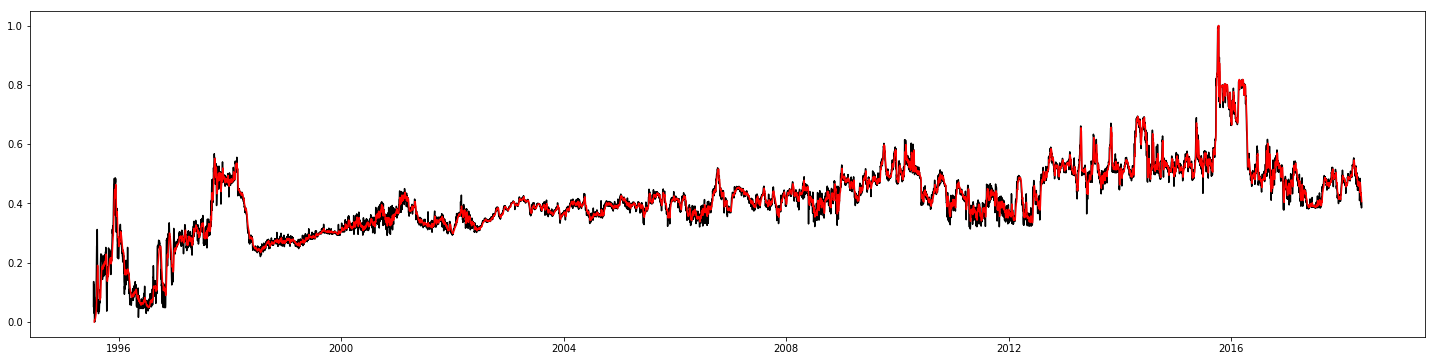

In [14]:
_, y_pred = train_model(d, 5, 0.05)
plot_trained_model(d, y_pred)

Ya se tiene los datos preparados.

In [ ]:
import sklearn.metrics
from scipy.special import inv_boxcox
from tqdm import tqdm_notebook as tqdm
import itertools

least_error = 10.0
bmodel = None
by_pred = None
bL = 0
bmu = 0
balpha = 0

def get_sse(y_pred, y_desired):
    return sklearn.metrics.mean_squared_error(y_desired, y_pred, sample_weight=None)

def denormalize(y, mn, mx):
    df = mx - mn
    return [(i * df) + mn for i in y]

def inverse_transform(y, alpha, mn, mx):
    return inv_boxcox(denormalize(y, mn, mx), alpha)

for (alpha, L, mu) in tqdm(itertools.product(np.arange(-1, 1, step=0.1), range(1, 20), np.arange(0.01, 1, step=0.01))):
    d, mn, mx = normalize(stats.boxcox(d_old,alpha=alpha)[0].tolist())
    model, y_pred = train_model(d, L, mu)
    y_pred = inverse_transform(y_pred, alpha, mn, mx)
    if np.isnan(y_pred).any():
        print('alpha: {0}, L: {1}, mu: {2}, the model is divergent'.format(alpha, L, mu))
    else:
        err = get_sse(y_pred[L:], d_old[L:])
        print('SSE: {0}, alpha: {1}, L: {2}, mu: {3}'.format(err, alpha, L, mu))
        if least_error > err:
            least_error = err
            bmodel = model
            by_pred = y_pred
            bL = L
            bmu = mu
            

alpha: -1.0, L: 1, mu: 0.01, the model is divergent
alpha: -1.0, L: 1, mu: 0.02, the model is divergent
alpha: -1.0, L: 1, mu: 0.03, the model is divergent
alpha: -1.0, L: 1, mu: 0.04, the model is divergent
alpha: -1.0, L: 1, mu: 0.05, the model is divergent
alpha: -1.0, L: 1, mu: 0.060000000000000005, the model is divergent
alpha: -1.0, L: 1, mu: 0.06999999999999999, the model is divergent
alpha: -1.0, L: 1, mu: 0.08, the model is divergent
alpha: -1.0, L: 1, mu: 0.09, the model is divergent
alpha: -1.0, L: 1, mu: 0.09999999999999999, the model is divergent
alpha: -1.0, L: 1, mu: 0.11, the model is divergent
alpha: -1.0, L: 1, mu: 0.12, the model is divergent
alpha: -1.0, L: 1, mu: 0.13, the model is divergent
alpha: -1.0, L: 1, mu: 0.14, the model is divergent
alpha: -1.0, L: 1, mu: 0.15000000000000002, the model is divergent
alpha: -1.0, L: 1, mu: 0.16, the model is divergent
alpha: -1.0, L: 1, mu: 0.17, the model is divergent
alpha: -1.0, L: 1, mu: 0.18000000000000002, the model i

alpha: -1.0, L: 2, mu: 0.48000000000000004, the model is divergent
alpha: -1.0, L: 2, mu: 0.49, the model is divergent
alpha: -1.0, L: 2, mu: 0.5, the model is divergent
alpha: -1.0, L: 2, mu: 0.51, the model is divergent
alpha: -1.0, L: 2, mu: 0.52, the model is divergent
alpha: -1.0, L: 2, mu: 0.53, the model is divergent
alpha: -1.0, L: 2, mu: 0.54, the model is divergent
alpha: -1.0, L: 2, mu: 0.55, the model is divergent
alpha: -1.0, L: 2, mu: 0.56, the model is divergent
alpha: -1.0, L: 2, mu: 0.5700000000000001, the model is divergent
alpha: -1.0, L: 2, mu: 0.5800000000000001, the model is divergent
alpha: -1.0, L: 2, mu: 0.59, the model is divergent
alpha: -1.0, L: 2, mu: 0.6, the model is divergent
alpha: -1.0, L: 2, mu: 0.61, the model is divergent
alpha: -1.0, L: 2, mu: 0.62, the model is divergent
alpha: -1.0, L: 2, mu: 0.63, the model is divergent
alpha: -1.0, L: 2, mu: 0.64, the model is divergent
alpha: -1.0, L: 2, mu: 0.65, the model is divergent
alpha: -1.0, L: 2, mu: 

alpha: -1.0, L: 3, mu: 0.9600000000000001, the model is divergent
alpha: -1.0, L: 3, mu: 0.97, the model is divergent
alpha: -1.0, L: 3, mu: 0.98, the model is divergent
alpha: -1.0, L: 3, mu: 0.99, the model is divergent
alpha: -1.0, L: 4, mu: 0.01, the model is divergent
alpha: -1.0, L: 4, mu: 0.02, the model is divergent
alpha: -1.0, L: 4, mu: 0.03, the model is divergent
alpha: -1.0, L: 4, mu: 0.04, the model is divergent
alpha: -1.0, L: 4, mu: 0.05, the model is divergent
alpha: -1.0, L: 4, mu: 0.060000000000000005, the model is divergent
alpha: -1.0, L: 4, mu: 0.06999999999999999, the model is divergent
alpha: -1.0, L: 4, mu: 0.08, the model is divergent
alpha: -1.0, L: 4, mu: 0.09, the model is divergent
alpha: -1.0, L: 4, mu: 0.09999999999999999, the model is divergent
alpha: -1.0, L: 4, mu: 0.11, the model is divergent
alpha: -1.0, L: 4, mu: 0.12, the model is divergent
alpha: -1.0, L: 4, mu: 0.13, the model is divergent
alpha: -1.0, L: 4, mu: 0.14, the model is divergent
alph

alpha: -1.0, L: 5, mu: 0.44, the model is divergent
alpha: -1.0, L: 5, mu: 0.45, the model is divergent
alpha: -1.0, L: 5, mu: 0.46, the model is divergent
alpha: -1.0, L: 5, mu: 0.47000000000000003, the model is divergent
alpha: -1.0, L: 5, mu: 0.48000000000000004, the model is divergent
alpha: -1.0, L: 5, mu: 0.49, the model is divergent
alpha: -1.0, L: 5, mu: 0.5, the model is divergent
alpha: -1.0, L: 5, mu: 0.51, the model is divergent
alpha: -1.0, L: 5, mu: 0.52, the model is divergent
alpha: -1.0, L: 5, mu: 0.53, the model is divergent
alpha: -1.0, L: 5, mu: 0.54, the model is divergent
alpha: -1.0, L: 5, mu: 0.55, the model is divergent
alpha: -1.0, L: 5, mu: 0.56, the model is divergent
alpha: -1.0, L: 5, mu: 0.5700000000000001, the model is divergent
alpha: -1.0, L: 5, mu: 0.5800000000000001, the model is divergent
alpha: -1.0, L: 5, mu: 0.59, the model is divergent
alpha: -1.0, L: 5, mu: 0.6, the model is divergent
alpha: -1.0, L: 5, mu: 0.61, the model is divergent
alpha: -

alpha: -1.0, L: 6, mu: 0.93, the model is divergent
alpha: -1.0, L: 6, mu: 0.9400000000000001, the model is divergent
alpha: -1.0, L: 6, mu: 0.9500000000000001, the model is divergent
alpha: -1.0, L: 6, mu: 0.9600000000000001, the model is divergent
alpha: -1.0, L: 6, mu: 0.97, the model is divergent
alpha: -1.0, L: 6, mu: 0.98, the model is divergent
alpha: -1.0, L: 6, mu: 0.99, the model is divergent
alpha: -1.0, L: 7, mu: 0.01, the model is divergent
alpha: -1.0, L: 7, mu: 0.02, the model is divergent
alpha: -1.0, L: 7, mu: 0.03, the model is divergent
alpha: -1.0, L: 7, mu: 0.04, the model is divergent
alpha: -1.0, L: 7, mu: 0.05, the model is divergent
alpha: -1.0, L: 7, mu: 0.060000000000000005, the model is divergent
alpha: -1.0, L: 7, mu: 0.06999999999999999, the model is divergent
alpha: -1.0, L: 7, mu: 0.08, the model is divergent
alpha: -1.0, L: 7, mu: 0.09, the model is divergent
alpha: -1.0, L: 7, mu: 0.09999999999999999, the model is divergent
alpha: -1.0, L: 7, mu: 0.11,

alpha: -1.0, L: 8, mu: 0.41000000000000003, the model is divergent
alpha: -1.0, L: 8, mu: 0.42000000000000004, the model is divergent
alpha: -1.0, L: 8, mu: 0.43, the model is divergent
alpha: -1.0, L: 8, mu: 0.44, the model is divergent
alpha: -1.0, L: 8, mu: 0.45, the model is divergent
alpha: -1.0, L: 8, mu: 0.46, the model is divergent
alpha: -1.0, L: 8, mu: 0.47000000000000003, the model is divergent
alpha: -1.0, L: 8, mu: 0.48000000000000004, the model is divergent
alpha: -1.0, L: 8, mu: 0.49, the model is divergent
alpha: -1.0, L: 8, mu: 0.5, the model is divergent
alpha: -1.0, L: 8, mu: 0.51, the model is divergent
alpha: -1.0, L: 8, mu: 0.52, the model is divergent
alpha: -1.0, L: 8, mu: 0.53, the model is divergent
alpha: -1.0, L: 8, mu: 0.54, the model is divergent
alpha: -1.0, L: 8, mu: 0.55, the model is divergent
alpha: -1.0, L: 8, mu: 0.56, the model is divergent
alpha: -1.0, L: 8, mu: 0.5700000000000001, the model is divergent
alpha: -1.0, L: 8, mu: 0.5800000000000001, 

alpha: -1.0, L: 9, mu: 0.89, the model is divergent
alpha: -1.0, L: 9, mu: 0.9, the model is divergent
alpha: -1.0, L: 9, mu: 0.91, the model is divergent
alpha: -1.0, L: 9, mu: 0.92, the model is divergent
alpha: -1.0, L: 9, mu: 0.93, the model is divergent
alpha: -1.0, L: 9, mu: 0.9400000000000001, the model is divergent
alpha: -1.0, L: 9, mu: 0.9500000000000001, the model is divergent
alpha: -1.0, L: 9, mu: 0.9600000000000001, the model is divergent
alpha: -1.0, L: 9, mu: 0.97, the model is divergent
alpha: -1.0, L: 9, mu: 0.98, the model is divergent
alpha: -1.0, L: 9, mu: 0.99, the model is divergent
alpha: -1.0, L: 10, mu: 0.01, the model is divergent
alpha: -1.0, L: 10, mu: 0.02, the model is divergent
alpha: -1.0, L: 10, mu: 0.03, the model is divergent
alpha: -1.0, L: 10, mu: 0.04, the model is divergent
alpha: -1.0, L: 10, mu: 0.05, the model is divergent
alpha: -1.0, L: 10, mu: 0.060000000000000005, the model is divergent
alpha: -1.0, L: 10, mu: 0.06999999999999999, the mode

alpha: -1.0, L: 11, mu: 0.35000000000000003, the model is divergent
alpha: -1.0, L: 11, mu: 0.36000000000000004, the model is divergent
alpha: -1.0, L: 11, mu: 0.37, the model is divergent
alpha: -1.0, L: 11, mu: 0.38, the model is divergent
alpha: -1.0, L: 11, mu: 0.39, the model is divergent
alpha: -1.0, L: 11, mu: 0.4, the model is divergent
alpha: -1.0, L: 11, mu: 0.41000000000000003, the model is divergent
alpha: -1.0, L: 11, mu: 0.42000000000000004, the model is divergent
alpha: -1.0, L: 11, mu: 0.43, the model is divergent
alpha: -1.0, L: 11, mu: 0.44, the model is divergent
alpha: -1.0, L: 11, mu: 0.45, the model is divergent
alpha: -1.0, L: 11, mu: 0.46, the model is divergent
alpha: -1.0, L: 11, mu: 0.47000000000000003, the model is divergent
alpha: -1.0, L: 11, mu: 0.48000000000000004, the model is divergent
alpha: -1.0, L: 11, mu: 0.49, the model is divergent
alpha: -1.0, L: 11, mu: 0.5, the model is divergent
alpha: -1.0, L: 11, mu: 0.51, the model is divergent
alpha: -1.0

alpha: -1.0, L: 12, mu: 0.8, the model is divergent
alpha: -1.0, L: 12, mu: 0.81, the model is divergent
alpha: -1.0, L: 12, mu: 0.8200000000000001, the model is divergent
alpha: -1.0, L: 12, mu: 0.8300000000000001, the model is divergent
alpha: -1.0, L: 12, mu: 0.8400000000000001, the model is divergent
alpha: -1.0, L: 12, mu: 0.85, the model is divergent
alpha: -1.0, L: 12, mu: 0.86, the model is divergent
alpha: -1.0, L: 12, mu: 0.87, the model is divergent
alpha: -1.0, L: 12, mu: 0.88, the model is divergent
alpha: -1.0, L: 12, mu: 0.89, the model is divergent
alpha: -1.0, L: 12, mu: 0.9, the model is divergent
alpha: -1.0, L: 12, mu: 0.91, the model is divergent
alpha: -1.0, L: 12, mu: 0.92, the model is divergent
alpha: -1.0, L: 12, mu: 0.93, the model is divergent
alpha: -1.0, L: 12, mu: 0.9400000000000001, the model is divergent
alpha: -1.0, L: 12, mu: 0.9500000000000001, the model is divergent
alpha: -1.0, L: 12, mu: 0.9600000000000001, the model is divergent
alpha: -1.0, L: 1

alpha: -1.0, L: 14, mu: 0.26, the model is divergent
alpha: -1.0, L: 14, mu: 0.27, the model is divergent
alpha: -1.0, L: 14, mu: 0.28, the model is divergent
